# NLP - Lazy rnn - lstm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_copom = pd.read_csv('df_copom_label_en.csv')

In [3]:
df_copom.head(1)

,Unnamed: 0,meeting_number,date_x,date_y,selic,decision,decision_txt,type,text,num_words,text_raw,num_words_raw,label_hawk_dove,label_next_meet
0,0,117,2006/03/08,2006/03/08,16.5,-0.75,decrease,statement,"march meeting , banco central brasil 's moneta...",55.0,"In the March Meeting, the Banco Central do Br...",67.0,dovish,decrease


In [4]:
df = df_copom[df_copom['type'] == 'statement'].copy()

In [5]:
df.head(1)

,Unnamed: 0,meeting_number,date_x,date_y,selic,decision,decision_txt,type,text,num_words,text_raw,num_words_raw,label_hawk_dove,label_next_meet
0,0,117,2006/03/08,2006/03/08,16.5,-0.75,decrease,statement,"march meeting , banco central brasil 's moneta...",55.0,"In the March Meeting, the Banco Central do Br...",67.0,dovish,decrease


In [6]:
df.shape

(140, 14)

In [7]:
df.isnull().sum()

Unnamed: 0         0
meeting_number     0
date_x             0
date_y             0
selic              0
decision           0
decision_txt       0
type               0
text               0
num_words          0
text_raw           0
num_words_raw      0
label_hawk_dove    1
label_next_meet    1
dtype: int64

In [8]:
df = df.dropna().copy()
df.shape

(139, 14)

In [9]:
df.isnull().sum()

Unnamed: 0         0
meeting_number     0
date_x             0
date_y             0
selic              0
decision           0
decision_txt       0
type               0
text               0
num_words          0
text_raw           0
num_words_raw      0
label_hawk_dove    0
label_next_meet    0
dtype: int64

### Split test and train

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = df.copy()
y = df['label_hawk_dove']

In [12]:
#Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2015)

In [13]:
texts = X_train['text'].tolist()
labels = y_train.tolist()

In [14]:
texts[0][:100]

'copom unanimously decided maintain selic rate 6.50 % p.a.the following observations provide update c'

In [15]:
labels[:5]

['neutral', 'hawkish', 'dovish', 'dovish', 'dovish']

In [16]:
len(texts), len(labels)

(111, 111)

In [17]:
# seq_len = 512 # number of the tokens tokenizer will create
# num_samples = len (texts)
# num_samples, seq_len

### Convert labels to one-hot encoded vectors

In [18]:
label_classes = list(set(labels))
num_classes = len(label_classes)

label_to_index = {label: index for index, label in enumerate(label_classes)}
index_to_label = {index: label for label, index in label_to_index.items()}

labels_encoded = np.array([label_to_index[label] for label in labels])
labels = np.eye(num_classes)[labels_encoded]

In [19]:
label_to_index

{'hawkish': 0, 'neutral': 1, 'dovish': 2}

In [20]:
labels[:5]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [21]:
len(labels)

111

## Model

In [22]:
import os
import sys

In [23]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

import tensorflow as tf

import keras.backend as K
# if len(K.tensorflow_backend._get_available_gpus()) > 0:
#   from keras.layers import CuDNNLSTM as LSTM
#   from keras.layers import CuDNNGRU as GRU

In [24]:
import keras
print(keras.__version__)

2.12.0


In [25]:
# some configuration
MAX_SEQUENCE_LENGTH = 600
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 100

In [26]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('glove.6B/glove.6B.50d.txt', encoding='utf-8') as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [27]:
# train = pd.read_csv("train.csv/train.csv")
# sentences = train["comment_text"].fillna("DUMMY_VALUE").values
# possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# targets = train[possible_labels].values

In [28]:
sentences = X_train['text'].fillna("DUMMY_VALUE").values
possible_labels = ['dovish', 'neutral', 'hawkish']
targets = labels

In [29]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [30]:
len(sequences)

111

In [31]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 1324 unique tokens.


In [32]:
# pad sequences so that we get a N x T matrix
data = tf.keras.utils.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (111, 600)


In [33]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [34]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [35]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy'],
)

Building model...


In [36]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.7209 - accuracy: 0.2614 - val_loss: 0.6398 - val_accuracy: 0.4348
Epoch 2/100
1/1 [==============================] - 0s 174ms/step - loss: 0.6458 - accuracy: 0.3409 - val_loss: 0.6329 - val_accuracy: 0.3478
Epoch 3/100
1/1 [==============================] - 0s 178ms/step - loss: 0.6241 - accuracy: 0.3864 - val_loss: 0.6450 - val_accuracy: 0.3478
Epoch 4/100
1/1 [==============================] - 0s 180ms/step - loss: 0.6206 - accuracy: 0.3977 - val_loss: 0.6537 - val_accuracy: 0.3478
Epoch 5/100
1/1 [==============================] - 0s 179ms/step - loss: 0.6171 - accuracy: 0.3977 - val_loss: 0.6517 - val_accuracy: 0.3478
Epoch 6/100
1/1 [==============================] - 0s 174ms/step - loss: 0.6099 - accuracy: 0.3977 - val_loss: 0.6417 - val_accuracy: 0.3478
Epoch 7/100
1/1 [==============================] - 0s 176ms/step - loss: 0.6000 - accuracy: 0.3977 - val_loss: 0.6307 - val_accuracy: 0.347

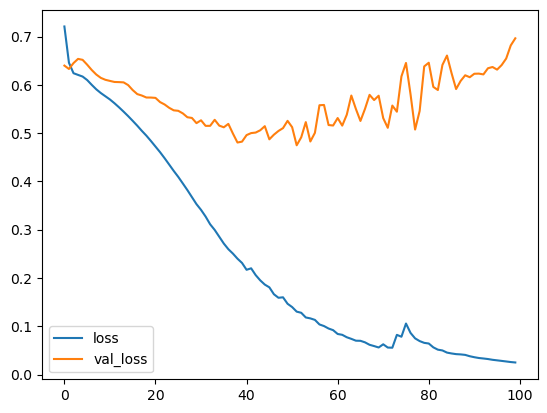

In [37]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

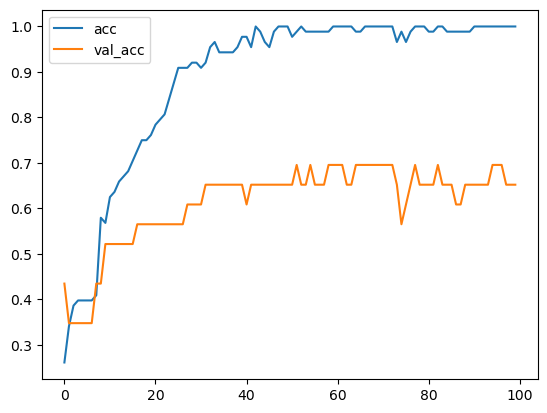

In [38]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [39]:
EPOCHS = 40

r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/40
1/1 [==============================] - 0s 191ms/step - loss: 0.0240 - accuracy: 1.0000 - val_loss: 0.6896 - val_accuracy: 0.6522
Epoch 2/40
1/1 [==============================] - 0s 165ms/step - loss: 0.0230 - accuracy: 1.0000 - val_loss: 0.6785 - val_accuracy: 0.6957
Epoch 3/40
1/1 [==============================] - 0s 172ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.6724 - val_accuracy: 0.6957
Epoch 4/40
1/1 [==============================] - 0s 168ms/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.6866 - val_accuracy: 0.6522
Epoch 5/40
1/1 [==============================] - 0s 163ms/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.7081 - val_accuracy: 0.6522
Epoch 6/40
1/1 [==============================] - 0s 166ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.7146 - val_accuracy: 0.6522
Epoch 7/40
1/1 [==============================] - 0s 168ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.6986 - val_accuracy: 0.6522
Epoch 8/40
1/1 [====

In [40]:
p = model.predict(data)
aucs = []
for j in range(3):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

4/4 [==============================] - 1s 28ms/step
0.9777112395618416


In [41]:
sentences_test = X_test['text'].fillna("DUMMY_VALUE").values

In [42]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences_test)
sequences_test = tokenizer.texts_to_sequences(sentences_test)

In [43]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 963 unique tokens.


In [44]:
# pad sequences so that we get a N x T matrix
data_test = tf.keras.utils.pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data_test.shape)

Shape of data tensor: (28, 600)


In [45]:
p = model.predict(data_test)

1/1 [==============================] - 0s 36ms/step


In [46]:
results = np.argmax(p, axis=1)

In [47]:
label = y_test.values

In [48]:
df = pd.DataFrame({'Label': label, 'Result': results})

In [49]:
df

,Label,Result
0,dovish,2
1,dovish,2
2,dovish,2
3,dovish,2
4,neutral,2
5,neutral,2
6,neutral,2
7,neutral,1
8,dovish,1
9,hawkish,0
